In [10]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
#%%
G = 6.6738e-8
PROTONMASS = 1.67262178e-24
ELECTRONMASS = 9.10938291e-28
BOLTZMANN = 1.38065e-16
THOMSON = 6.652458734e-25
XH = 0.76
GAMMA = 5.0/3
LIGHTSPEED = 2.99792458e10

def Read_Header(base, run, snapnum):
    ext                  = '099.'+str(snapnum)    
    fn                   = base+run+'/fof_subhalo_tab_'+ext+'.hdf5'
    fs                   = h5.File(fn, 'r')
    Header               = fs['Header'].attrs
    Redshift             = Header['Redshift']
    a                    = Header['Time']
    Omega                = [Header['Omega0'], Header['OmegaLambda']]
    h                    = Header['HubbleParam']   
    BoxSize              = Header['BoxSize']*a/h 
    UnitLength           = 3.086e19
    UnitMass             = 1.989e43
    UnitVelocity         = 1e5
    UnitTime             = UnitLength/UnitVelocity

    return {'BoxSize':BoxSize, 'Omega':Omega, 'a':a, 'Redshift':Redshift,
            'h':h, 
            'UnitLength':UnitLength, 'UnitMass':UnitMass,
            'UnitVelocity':UnitVelocity, 'UnitTime':UnitTime}


def Read_Halos(base, run, snapnum):

    ext                  = '099.'+str(snapnum)+'.hdf5'    
    fn                   = base+run+'/fof_subhalo_tab_'+ext
    fs                   = h5.File(fn, 'r')

    try:
        fs['Group/Group_M_Crit200'][:] 
    except: 
        return {}
    Header               = fs['Header'].attrs
    a, h = Header['Time'], Header['HubbleParam']
    TotNgroups           = Header['Ngroups_Total']
    TotNsubgroups        = Header['Nsubgroups_Total']
    

    if TotNgroups > 0:
        Gr_LenType       = fs['Group/GroupLenType'][:]
        validgroup = (Gr_LenType[:,1] >= 200)
        if len(Gr_LenType[validgroup,1]) == 0: return {}
        invalidgroup = np.where(Gr_LenType[:,1] < 200)[0]
        Gr_LenType       = fs['Group/GroupLenType'][validgroup,:]
        Gr_MCrit200      = fs['Group/Group_M_Crit200'][validgroup] / h
        Gr_RCrit200      = fs['Group/Group_R_Crit200'][validgroup] * a / h
        Gr_MCrit500      = fs['Group/Group_M_Crit500'][validgroup] / h
        Gr_RCrit500      = fs['Group/Group_R_Crit500'][validgroup] * a / h
        Gr_Mass          = fs['Group/GroupMass'][validgroup] / h
        Gr_Pos           = fs['Group/GroupPos'][validgroup,:] * a / h
        Gr_Vel           = fs['Group/GroupVel'][validgroup,:] * 1/a
        FirstSub         = fs['Group/GroupFirstSub'][validgroup]
        NumSubs          = fs['Group/GroupNsubs'][validgroup]
    if TotNsubgroups > 0:    
        SubGroupNumber   = fs['Subhalo/SubhaloGrNr'][:]
        validsub = np.isin(SubGroupNumber, invalidgroup, invert=True)
        SubGroupNumber   = fs['Subhalo/SubhaloGrNr'][validsub]        
        SubPos           = fs['Subhalo/SubhaloPos'][validsub,:] * a / h
        SubLenType       = fs['Subhalo/SubhaloLenType'][validsub,:]
        SubMassType      = fs['Subhalo/SubhaloMassInHalfRadType'][validsub,:] / h
        SubVel           = fs['Subhalo/SubhaloVel'][validsub,:]
        SubHalfRad       = fs['Subhalo/SubhaloHalfmassRadType'][validsub,:] * a / h
        SubLen           = fs['Subhalo/SubhaloLen'][validsub]



    return {'Group_M_Crit200':Gr_MCrit200, 'Group_R_Crit200':Gr_RCrit200, 'Group_M_Crit500':Gr_MCrit500, 'Group_R_Crit500':Gr_RCrit500,  'GroupLenType':Gr_LenType, 
            'GroupMass':Gr_Mass,           'GroupPos':Gr_Pos, 'FirstSub':FirstSub,               
            'NumOfSubhalos':NumSubs,       
            'SubLen':SubLen,               'SubPos':SubPos,   'SubVel':SubVel, 'SubGroupNumber':SubGroupNumber,
            'TotNgroups':TotNgroups,       'TotNsubgroups':TotNsubgroups,                 
            'SubLenType':SubLenType,       'SubMassType':SubMassType,  
            'GroupVel':Gr_Vel, 'SubHalfRad':SubHalfRad}

In [11]:
base = '/data/ERCblackholes2/jsb210/HackWeek19/'
# base = '/home/jsb/HackWeek/'
run = 'EAGLE'



#%%
print('Importing data...')
EAGLEdat = np.loadtxt(base+run+'/result.csv', skiprows=45, delimiter=',')
print('Data imported')
print(EAGLEdat.shape)
E_mdm   = EAGLEdat[:,2]
cut = np.where(E_mdm/1.81e6 > 200)[0]
mdm   = E_mdm[cut][np.nonzero(EAGLEdat[:,2][cut])]
mstar = EAGLEdat[:,0][cut][np.nonzero(EAGLEdat[:,0][cut])]
mbh   = EAGLEdat[:,1][cut][np.nonzero(EAGLEdat[:,1][cut])]
mgas  = EAGLEdat[:,3][cut][np.nonzero(EAGLEdat[:,3][cut])]
mvir  = np.unique(EAGLEdat[:,4][np.nonzero(EAGLEdat[:,4])])
rvir  = np.unique(EAGLEdat[:,5][np.nonzero(EAGLEdat[:,5])])
halfstarrad = EAGLEdat[:,6][cut][np.nonzero(EAGLEdat[:,6][cut])]
mbary = (EAGLEdat[:,0][cut]+EAGLEdat[:,1][cut]+EAGLEdat[:,3][cut])
mbary = mbary[np.nonzero(mbary)]
#%%

Importing data...
Data imported
(2275478, 7)


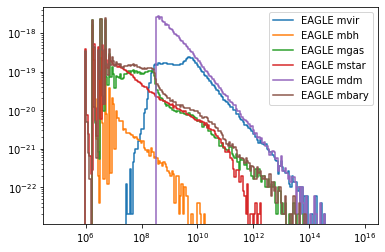

In [12]:
bs = 100*1e6

mbins = np.arange(5, 16, 0.05) #np.linspace(5, np.log10(5e15), 200)
binwidth = np.diff(mbins)
w = (1/(bs)**3)

mtype = ['mvir', 'mbh', 'mgas', 'mstar', 'mdm', 'mbary']
#%%
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
for i in mtype:
    h, edges = np.histogram(np.log10(eval(i)), bins=mbins, weights=np.full_like(eval(i), w))
    edges = edges[:-1] + np.diff(edges)/2
    ax.step(10**edges,  h/binwidth,  label=run+' '+i)
    massnumdens = np.vstack((edges, binwidth, h, h/binwidth)).T
    np.savetxt('BigPlotData_'+run+'_'+i+'.txt', massnumdens, header='[0] log10 Mass / Msun, [1] Bin width log10 Mass / Msun, [2] dN/dV (pc^-3), [3] dN/dVlogM (pc^-3 log10 Mass/Msun)')


ax.legend()


#wget --http-user=lbd819 --http-passwd=wng92fes "http://galaxy-catalogue.dur.ac.uk:8080/Eagle?action=doQuery&SQL=select SH.MassType_Star as mstar, SH.MassType_BH as mbh, SH.MassType_DM as mdm, SH.MassType_Gas as mgas, FOF.Group_M_Crit200 as mvir, FOF.Group_R_Crit200 as rvir, SH.HalfMassRad_Star as HalfRadStar from RefL0100N1504_Subhalo as SH, RefL0100N1504_FOF as FOF where SH.SnapNum = 28 and FOF.SnapNum = SH.SnapNum" -O result.csv                 